In [1]:
import numpy as np
from scipy import misc
from PIL import Image
import glob
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import cv2
import seaborn as sn  
import pandas as pd  
import pickle  
from keras import layers  
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout  
from keras.models import Sequential, Model, load_model  
from keras.preprocessing import image  
from keras.preprocessing.image import load_img  
from keras.preprocessing.image import img_to_array  
from keras.applications.imagenet_utils import decode_predictions  
from keras.utils import layer_utils, np_utils  
from keras.utils.data_utils import get_file  
from keras.applications.imagenet_utils import preprocess_input  
from keras.utils.vis_utils import model_to_dot  
from keras.utils import plot_model  
from keras.initializers import glorot_uniform  
from keras import losses  
import keras.backend as K  
from keras.callbacks import ModelCheckpoint  
from sklearn.metrics import confusion_matrix, classification_report  
import tensorflow as tf
import os
import os.path

Using TensorFlow backend.


In [2]:
# Ruta de la imagen y extensiones válidas.
imageDir = 'D:/Competicion/WIDS/train_images/' #Especific tu ruta aqui
image_path_list = []
valid_image_extensions = [".jpg", ".jpeg", ".png", ".tif", ".tiff"] # Especifique sus extensiones vald aquí
valid_image_extensions = [item.lower() for item in valid_image_extensions]

# Crear una lista de todos los archivos en el directorio y
# Adjuntar archivos con una extensión válida a la lista image_path
for file in os.listdir(imageDir):
    extension = os.path.splitext(file)[1]
    if extension.lower() not in valid_image_extensions:
        continue
    image_path_list.append(os.path.join(imageDir, file))

# close any open windows
cv2.destroyAllWindows()

In [3]:
images = []
for value in image_path_list:
    images.append(value.split('/')[4])

In [4]:
orden_image = pd.DataFrame({'image_id':images,'orden':range(15244)})

In [5]:
np.shape(image_path_list)

(15244,)

In [6]:
x_train_original = np.empty((15244, 256, 256, 3), dtype=np.uint8)
for i, fpath in enumerate(image_path_list):
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    x_train_original[i, ...] = img.transpose(0, 1, 2)

In [7]:
x_train_original.shape

(15244, 256, 256, 3)

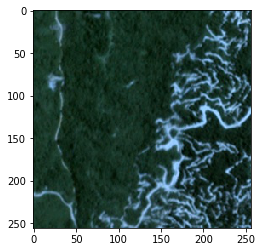

In [8]:
imgplot = plt.imshow(x_train_original[1])
plt.show()

**Cargando Labels en DataFrame**

In [9]:
y_train_original = pd.read_csv('D:/Competicion/WIDS/traininglabels.csv',sep = ',')

In [10]:
y_train_original = y_train_original.merge(orden_image)

In [11]:
y_train_original.sort_values(by = 'orden', ascending = True, inplace = True)

In [12]:
y_tot = pd.DataFrame({'has_oilpalm':y_train_original['has_oilpalm'].values,'orden':y_train_original['orden']})

In [13]:
len(y_tot['has_oilpalm'])

15244

In [14]:
sum(y_tot['has_oilpalm'])

942

**Sacando Train,Test - Metodo 2**

In [15]:
import random 
c = range(15244)
sample = random.sample(c,12195)
sample_train = []
sample_test = []
for m in c:
    if m in sample:
        sample_train.append(m)
    else:
        sample_test.append(m)

In [16]:
sample_test_data = pd.DataFrame({'orden':sample_test,'tipo_base':'data_Test'})
sample_train_data = pd.DataFrame({'orden':sample_train,'tipo_base':'data_Train_total'})

In [17]:
y_validation = y_tot.merge(sample_test_data)
len(y_validation)

3049

In [18]:
y_train_test = y_tot.merge(sample_train_data,how = 'right')
len(y_train_test)

12195

In [19]:
del m
c_tr = range(12195)
sample_tr = random.sample(c_tr,2439)
sample_train = []
sample_val_tot = []
for m in c_tr:
    if m in sample_tr:
        sample_train.append(m)
    else:
        sample_val_tot.append(m)

In [20]:
sample_train_data = pd.DataFrame({'orden2':sample_train,'tipo_base2':'data_train'})
sample_valtot_data = pd.DataFrame({'orden2':sample_val_tot,'tipo_base2':'data_val_tot'})

In [21]:
y_train_test['orden2'] = range(12195)

In [22]:
y_train_prev = y_train_test.merge(sample_train_data)
len(y_train_prev)

2439

In [23]:
y_val_total = y_train_test.merge(sample_valtot_data,how = 'right')
len(y_val_total)

9756

In [24]:
del m
c_val = range(9756)
sample_val = random.sample(c_val,2134)
sample_validation = []
for m in c_val:
    if m in sample_val:
        sample_validation.append(m)

In [25]:
sample_validation_data = pd.DataFrame({'orden3':sample_validation,'tipo_base3':'data_validation'})

In [26]:
y_val_total['orden3'] = range(9756)

In [27]:
y_test_prev = y_val_total.merge(sample_validation_data)
len(y_test_prev)

2134

In [28]:
y_train = pd.DataFrame({'has_oilpalm':y_train_prev['has_oilpalm'],'orden':y_train_prev['orden']})
y_train = np_utils.to_categorical(y_train['has_oilpalm'], 2)
y_train.shape

(2439, 2)

In [29]:
y_test = pd.DataFrame({'has_oilpalm':y_test_prev['has_oilpalm'],'orden':y_test_prev['orden']})
y_test = np_utils.to_categorical(y_test['has_oilpalm'], 2)
y_test.shape

(2134, 2)

In [30]:
data_train = list(y_train_prev['orden'])
data_test = list(y_test_prev['orden'])

In [31]:
x_train = (x_train_original[data_train] / 255)
x_train.shape

(2439, 256, 256, 3)

In [32]:
x_test = (x_train_original[data_test] / 255)
x_test.shape

(2134, 256, 256, 3)

In [33]:
K.set_image_data_format('channels_last')

In [34]:
K.set_learning_phase(1)

In [38]:
def create_simple_nn():
    model = Sequential()
    model.add(Flatten(input_shape=(256, 256, 3), name="Input_layer"))
    model.add(Dense(256, activation='relu', name="Hidden_layer_1"))
    model.add(Dropout(rate = 0.1))
    model.add(Dense(128, activation='relu', name="Hidden_layer_2"))
    model.add(Dropout(rate = 0.2))
    model.add(Dense(64, activation='relu', name="Hidden_layer_3"))
    model.add(Dropout(rate = 0.3))
    model.add(Dense(32, activation='relu', name="Hidden_layer_4"))
    model.add(Dropout(rate = 0.4))
    model.add(Dense(16, activation='relu', name="Hidden_layer_5"))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(2, activation='softmax', name="Output_layer"))
    
    return model

In [39]:
snn_model = create_simple_nn()  
snn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])  

In [40]:
snn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Flatten)        (None, 196608)            0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 256)               50331904  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
Hidden_layer_3 (Dense)       (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
__________

In [41]:
snn = snn_model.fit(x=x_train, y=y_train, batch_size=32, epochs=5, verbose=1, validation_data=(x_test, y_test), shuffle=True)

Train on 2439 samples, validate on 2134 samples
Epoch 1/5
2439/2439 [==============================] - 29s 12ms/step - loss: 0.4213 - acc: 0.9041 - mean_squared_error: 0.1125 - val_loss: 0.3451 - val_acc: 0.9372 - val_mean_squared_error: 0.0905
Epoch 2/5
2439/2439 [==============================] - 26s 11ms/step - loss: 0.3833 - acc: 0.9274 - mean_squared_error: 0.0990 - val_loss: 0.3192 - val_acc: 0.9447 - val_mean_squared_error: 0.0806
Epoch 3/5
2439/2439 [==============================] - 27s 11ms/step - loss: 0.3566 - acc: 0.9287 - mean_squared_error: 0.0921 - val_loss: 0.2966 - val_acc: 0.9466 - val_mean_squared_error: 0.0706
Epoch 4/5
2439/2439 [==============================] - 26s 11ms/step - loss: 0.3307 - acc: 0.9299 - mean_squared_error: 0.0839 - val_loss: 0.2892 - val_acc: 0.9461 - val_mean_squared_error: 0.0698
Epoch 5/5
2439/2439 [==============================] - 28s 11ms/step - loss: 0.3256 - acc: 0.9307 - mean_squared_error: 0.0818 - val_loss: 0.2657 - val_acc: 0.9466 

In [42]:
evaluation = snn_model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)  
evaluation

2134/2134 [==============================] - 4s 2ms/step


[0.2592754982614361, 0.9465791940018744, 0.06217013543511845]

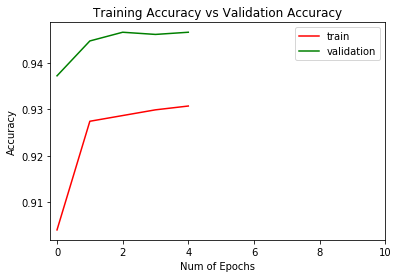

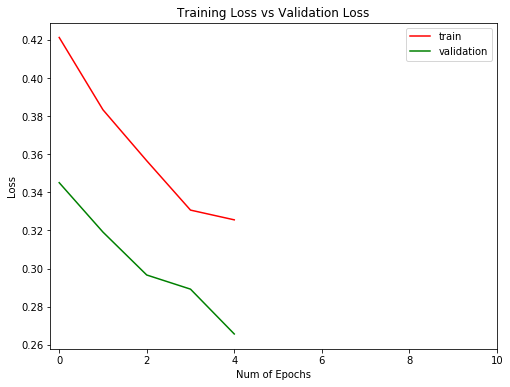

In [43]:
plt.figure(0)  
plt.plot(snn.history['acc'],'r')  
plt.plot(snn.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(snn.history['loss'],'r')  
plt.plot(snn.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()

In [44]:
snn_pred = snn_model.predict(x_test, batch_size=32, verbose=1)  
snn_predicted = np.argmax(snn_pred, axis=1) 

2134/2134 [==============================] - 4s 2ms/step


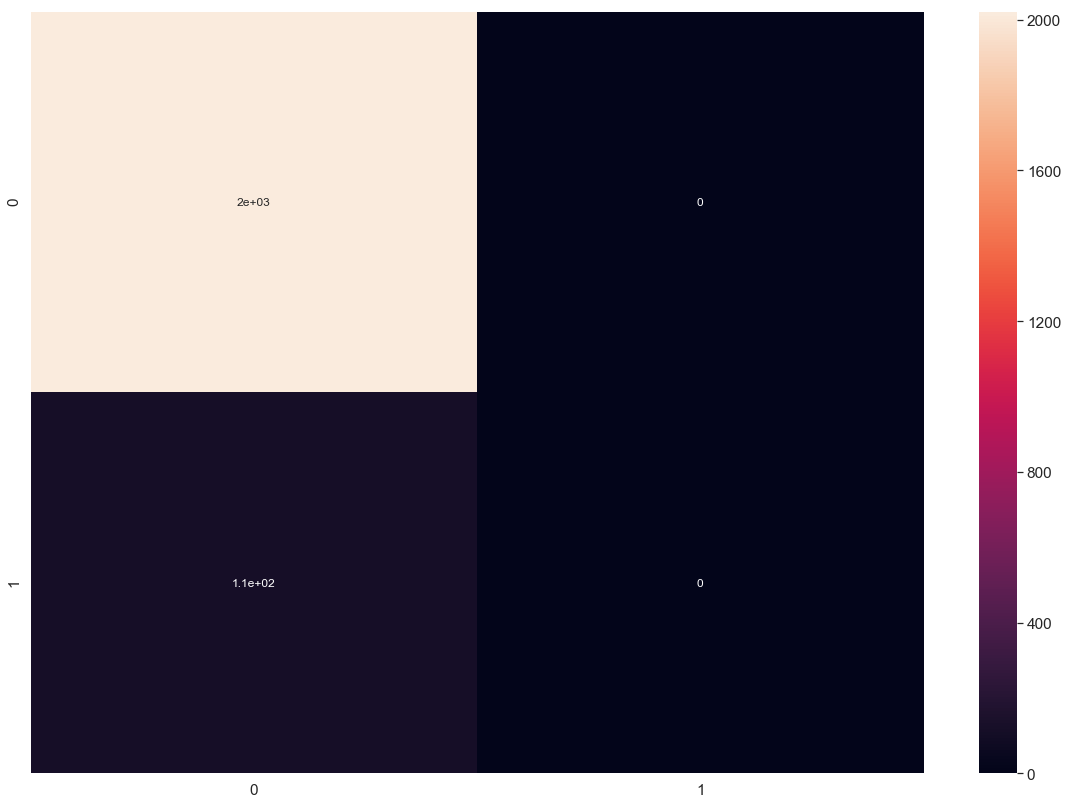

In [45]:
#Creamos la matriz de confusión
snn_cm = confusion_matrix(np.argmax(y_test, axis=1), snn_predicted)

# Visualizamos la matriz de confusión
snn_df_cm = pd.DataFrame(snn_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

In [46]:
snn_report = classification_report(np.argmax(y_test, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2020
           1       0.00      0.00      0.00       114

   micro avg       0.95      0.95      0.95      2134
   macro avg       0.47      0.50      0.49      2134
weighted avg       0.90      0.95      0.92      2134



C:\Users\Michael\Anaconda3\envs\Python_3.6\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Michael\Anaconda3\envs\Python_3.6\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Michael\Anaconda3\envs\Python_3.6\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


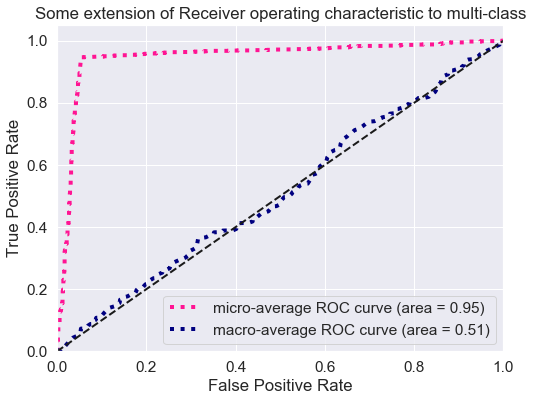

KeyError: 2

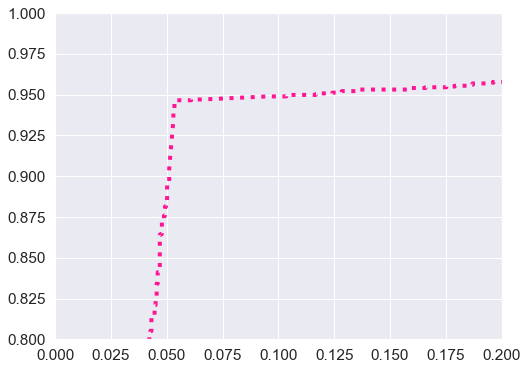

In [47]:
from sklearn.datasets import make_classification  
from sklearn.preprocessing import label_binarize  
from scipy import interp  
from itertools import cycle

n_classes = 2

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()  
tpr = dict()  
roc_auc = dict()  
for i in range(n_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())  
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)  
for i in range(n_classes):  
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr  
tpr["macro"] = mean_tpr  
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(n_classes-97), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)  
plt.xlim(0, 0.2)  
plt.ylim(0.8, 1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(3), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show() 